In [7]:
#Imports and Initial Setup
import pandas as pd
import numpy as np
from datasets import load_dataset
import json
import re
from typing import List, Dict, Any
import logging
import warnings
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("Imports and setup completed.")

Imports and setup completed.


In [8]:
#Quote Data Processor Class
class QuoteDataProcessor:
    def __init__(self):
        self.dataset = None
        self.processed_data = None
    
    def load_data(self):
        logger.info("Loading english_quotes dataset...")
        try:
            self.dataset = load_dataset("Abirate/english_quotes")
            logger.info(f"Dataset loaded successfully. Size: {len(self.dataset['train'])}")
            return True
        except Exception as e:
            logger.error(f"Error loading dataset: {e}")
            return False
    
    def clean_text(self, text: str) -> str:
        if not isinstance(text, str):
            return ""
        text = re.sub(r'\s+', ' ', text).strip()
        text = re.sub(r'[^\w\s\.\,\!\?\;\:\-\'\"]', ' ', text)
        return text
    
    def preprocess_data(self):
        #Preprocess and clean the dataset
        logger.info("Preprocessing data...")
        df = pd.DataFrame(self.dataset['train'])
        df['quote'] = df['quote'].apply(self.clean_text)
        df['author'] = df['author'].fillna('Unknown').apply(self.clean_text)
        df['tags'] = df['tags'].apply(lambda x: [tag.strip() for tag in x] if isinstance(x, list) else [])
        df = df[df['quote'].str.len() > 0]
        df['combined_text'] = df.apply(
            lambda row: f"Quote: {row['quote']} | Author: {row['author']} | Tags: {', '.join(row['tags'])}", 
            axis=1
        )
        self.processed_data = df
        logger.info(f"Data preprocessing completed. Final size: {len(df)}")
        return df
    
    def save_processed_data(self, filepath: str = "processed_quotes.json"):
        """Save processed data to JSON"""
        if self.processed_data is not None:
            self.processed_data.to_json(filepath, orient='records', indent=2)
            logger.info(f"Processed data saved to {filepath}")

print("QuoteDataProcessor class defined.")

QuoteDataProcessor class defined.


In [9]:
#Load and Preprocess Data
processor = QuoteDataProcessor()
if processor.load_data():
    df = processor.preprocess_data()
    processor.save_processed_data()
    print(f"Dataset loaded and preprocessed. Size: {len(df)}")
    print(df.head())
else:
    print("Failed to load dataset.")

INFO:__main__:Loading english_quotes dataset...
INFO:__main__:Dataset loaded successfully. Size: 2508
INFO:__main__:Preprocessing data...
INFO:__main__:Data preprocessing completed. Final size: 2508
INFO:__main__:Processed data saved to processed_quotes.json


Dataset loaded and preprocessed. Size: 2508
                                               quote                 author  \
0      Be yourself; everyone else is already taken.             Oscar Wilde   
1   I'm selfish, impatient and a little insecure....         Marilyn Monroe   
2   Two things are infinite: the universe and hum...        Albert Einstein   
3                    So many books, so little time.             Frank Zappa   
4   A room without books is like a body without a...  Marcus Tullius Cicero   

                                                tags  \
0  [be-yourself, gilbert-perreira, honesty, inspi...   
1  [best, life, love, mistakes, out-of-control, t...   
2  [human-nature, humor, infinity, philosophy, sc...   
3                                     [books, humor]   
4                              [books, simile, soul]   

                                       combined_text  
0  Quote:  Be yourself; everyone else is already ...  
1  Quote:  I'm selfish, impatient 

In [10]:
#Quote Embedding Model Class
from sentence_transformers import SentenceTransformer, InputExample, losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from torch.utils.data import DataLoader

class QuoteEmbeddingModel:
    def __init__(self, model_name: str = "all-MiniLM-L6-v2"):
        self.model_name = model_name
        self.model = None
        self.is_fine_tuned = False
    
    def load_base_model(self):
        """Load the base sentence transformer model"""
        logger.info(f"Loading base model: {self.model_name}")
        self.model = SentenceTransformer(self.model_name)
        return self.model
    
    def prepare_training_data(self, df: pd.DataFrame, sample_size: int = 1000):
        """Prepare training data for fine-tuning"""
        logger.info("Preparing training data for fine-tuning...")
        train_examples = []
        sample_df = df.sample(n=min(sample_size, len(df)), random_state=42)
        for _, row in sample_df.iterrows():
            train_examples.append(InputExample(
                texts=[row['quote'], f"Author: {row['author']}"],
                label=1.0
            ))
            for tag in row['tags'][:2]:
                train_examples.append(InputExample(
                    texts=[row['quote'], f"Tag: {tag}"],
                    label=0.8
                ))
        logger.info(f"Created {len(train_examples)} training examples")
        return train_examples
    
    def fine_tune_model(self, df: pd.DataFrame, epochs: int = 1, batch_size: int = 16):
        """Fine-tune the sentence transformer model"""
        if self.model is None:
            self.load_base_model()
        logger.info("Starting model fine-tuning...")
        train_examples = self.prepare_training_data(df)
        train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
        train_loss = losses.CosineSimilarityLoss(self.model)
        self.model.fit(
            train_objectives=[(train_dataloader, train_loss)],
            epochs=epochs,
            warmup_steps=100,
            output_path='./fine_tuned_quote_model'
        )
        self.is_f_fine_tuned = True
        logger.info("Model fine-tuning completed!")
        return self.model
    
    def save_model(self, path: str = "./fine_tuned_quote_model"):
        """Save the fine-tuned model"""
        if self.model:
            self.model.save(path)
            logger.info(f"Model saved to {path}")
    
    def load_model(self, path: str = "./fine_tuned_quote_model"):
        """Load a fine-tuned model"""
        try:
            self.model = SentenceTransformer(path)
            self.is_fine_tuned = True
            logger.info(f"Fine-tuned model loaded from {path}")
        except:
            logger.info("Fine-tuned model not found, loading base model...")
            self.load_base_model()
        return self.model

print("QuoteEmbeddingModel class defined.")

QuoteEmbeddingModel class defined.


In [11]:
#Load or Fine-Tune Model
embedding_model = QuoteEmbeddingModel()
model = embedding_model.load_model()  # Try loading fine-tuned model
# Optional: Fine-tune if you want (uncomment to run, takes time)
embedding_model.fine_tune_model(df, epochs=1)
embedding_model.save_model()
print("Embedding model loaded.")

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: ./fine_tuned_quote_model
INFO:__main__:Fine-tuned model not found, loading base model...
INFO:__main__:Loading base model: all-MiniLM-L6-v2
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:__main__:Starting model fine-tuning...
INFO:__main__:Preparing training data for fine-tuning...
INFO:__main__:Created 2692 training examples


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/169 [00:00<?, ?it/s]

INFO:sentence_transformers.SentenceTransformer:Save model to ./fine_tuned_quote_model
INFO:__main__:Model fine-tuning completed!
INFO:sentence_transformers.SentenceTransformer:Save model to ./fine_tuned_quote_model
INFO:__main__:Model saved to ./fine_tuned_quote_model


Embedding model loaded.


In [12]:
#RAG Quote Pipeline Class
import faiss
from typing import Tuple

class RAGQuotePipeline:
    def __init__(self, model: SentenceTransformer, df: pd.DataFrame):
        self.model = model
        self.df = df
        self.index = None
        self.embeddings = None
        self.llm_client = None
    
    def create_embeddings(self):
        """Create embeddings for all quotes"""
        logger.info("Creating embeddings for all quotes...")
        texts = self.df['combined_text'].tolist()
        self.embeddings = self.model.encode(texts, show_progress_bar=True)
        logger.info(f"Created embeddings with shape: {self.embeddings.shape}")
        return self.embeddings
    
    def build_faiss_index(self):
        """Build FAISS index for similarity search"""
        if self.embeddings is None:
            self.create_embeddings()
        logger.info("Building FAISS index...")
        dimension = self.embeddings.shape[1]
        self.index = faiss.IndexFlatIP(dimension)
        faiss.normalize_L2(self.embeddings)
        self.index.add(self.embeddings.astype('float32'))
        logger.info(f"FAISS index built with {self.index.ntotal} vectors")
        return self.index
    
    def setup_llm(self, use_ollama: bool = True):
        """Setup LLM for generation"""
        if use_ollama:
            try:
                import ollama
                self.llm_client = ollama.Client()
                logger.info("Ollama client initialized")
            except ImportError:
                logger.error("Ollama not installed. Using fallback response generator")
                self.llm_client = "fallback"
        else:
            self.llm_client = "fallback"
        return self.llm_client
    
    def retrieve_quotes(self, query: str, top_k: int = 5) -> List[Dict]:
        """Retrieve relevant quotes based on query"""
        if self.index is None:
            self.build_faiss_index()
        query_embedding = self.model.encode([query])
        faiss.normalize_L2(query_embedding)
        scores, indices = self.index.search(query_embedding.astype('float32'), top_k)
        results = []
        for i, (score, idx) in enumerate(zip(scores[0], indices[0])):
            if idx < len(self.df):
                quote_data = self.df.iloc[idx]
                results.append({
                    'rank': i + 1,
                    'score': float(score),
                    'quote': quote_data['quote'],
                    'author': quote_data['author'],
                    'tags': quote_data['tags'],
                    'combined_text': quote_data['combined_text']
                })
        return results
    
    def generate_response(self, query: str, retrieved_quotes: List[Dict]) -> str:
        """Generate response using LLM"""
        context = "\n".join([
            f"Quote {i+1}: \"{quote['quote']}\" - {quote['author']} (Tags: {', '.join(quote['tags'])})"
            for i, quote in enumerate(retrieved_quotes[:3])
        ])
        prompt = f"""Based on the following quotes, provide a comprehensive answer to the user's query.
Query: {query}
Relevant Quotes:
{context}
Please provide a structured response that includes:
1. A brief summary addressing the query
2. The most relevant quotes with their authors
3. Any insights or connections between the quotes
Response:"""
        if self.llm_client and self.llm_client != "fallback":
            try:
                response = self.llm_client.generate(model='llama2', prompt=prompt)
                return response['response']
            except Exception as e:
                logger.error(f"Error with Ollama: {e}")
                return self._fallback_response(query, retrieved_quotes)
        else:
            return self._fallback_response(query, retrieved_quotes)
    
    def _fallback_response(self, query: str, retrieved_quotes: List[Dict]) -> str:
        """Fallback response when LLM is not available"""
        if not retrieved_quotes:
            return "No relevant quotes found for your query."
        response = f"Here are the most relevant quotes for '{query}':\n\n"
        for i, quote in enumerate(retrieved_quotes[:3], 1):
            response += f"{i}. \"{quote['quote']}\"\n"
            response += f"   - Author: {quote['author']}\n"
            if quote['tags']:
                response += f"   - Tags: {', '.join(quote['tags'])}\n"
            response += f"   - Relevance Score: {quote['score']:.3f}\n\n"
        return response
    
    def query(self, user_query: str, top_k: int = 5) -> Dict[str, Any]:
        """Main query function that combines retrieval and generation"""
        logger.info(f"Processing query: {user_query}")
        retrieved_quotes = self.retrieve_quotes(user_query, top_k)
        generated_response = self.generate_response(user_query, retrieved_quotes)
        return {
            'query': user_query,
            'response': generated_response,
            'retrieved_quotes': retrieved_quotes,
            'num_results': len(retrieved_quotes)
        }

print("RAGQuotePipeline class defined.")

RAGQuotePipeline class defined.


In [13]:
#Initialize RAG Pipeline
rag_pipeline = RAGQuotePipeline(model, df)
rag_pipeline.setup_llm(use_ollama=False)  # Set to True if Ollama is installed
print("RAG pipeline initialized.")

RAG pipeline initialized.


In [14]:
#Test Query
test_query = "Motivational quotes about success"
result = rag_pipeline.query(test_query)
print("Query:", result['query'])
print("Response:", result['response'])
print("Retrieved Quotes:")
for quote in result['retrieved_quotes']:
    print(f"- {quote['quote']} (Author: {quote['author']}, Score: {quote['score']:.3f})")

INFO:__main__:Processing query: Motivational quotes about success
INFO:__main__:Creating embeddings for all quotes...


Batches:   0%|          | 0/79 [00:00<?, ?it/s]

INFO:__main__:Created embeddings with shape: (2508, 384)
INFO:__main__:Building FAISS index...
INFO:__main__:FAISS index built with 2508 vectors


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Query: Motivational quotes about success
Response: Here are the most relevant quotes for 'Motivational quotes about success':

1. " Success is getting what you want, happiness is wanting what you get "
   - Author: W. P. Kinsella
   - Tags: happiness, success
   - Relevance Score: 0.951

2. " You never fail until you stop trying. "
   - Author: Albert Einstein
   - Tags: inspirational
   - Relevance Score: 0.947

3. " The starting point of all achievement is DESIRE. Keep this constantly in mind. Weak desire brings weak results, just as a small fire makes a small amount of heat. "
   - Author: Napoleon Hill,
   - Tags: inspirational
   - Relevance Score: 0.946


Retrieved Quotes:
-  Success is getting what you want, happiness is wanting what you get  (Author: W. P. Kinsella, Score: 0.951)
-  You never fail until you stop trying.  (Author: Albert Einstein, Score: 0.947)
-  The starting point of all achievement is DESIRE. Keep this constantly in mind. Weak desire brings weak results, just

In [15]:
#RAG Evaluator Class
from ragas import evaluate
from ragas.metrics import faithfulness, answer_relevancy, context_recall, context_precision
from datasets import Dataset

class RAGEvaluator:
    def __init__(self, rag_pipeline: RAGQuotePipeline):
        self.rag_pipeline = rag_pipeline
        self.test_queries = [
            "Quotes about insanity attributed to Einstein",
            "Motivational quotes tagged 'accomplishment'",
            "All Oscar Wilde quotes with humor",
            "Quotes about love and life",
            "Inspirational quotes by women authors",
            "Quotes about courage and bravery",
            "Philosophical quotes about existence",
            "Quotes about success and failure"
        ]
    
    def prepare_evaluation_data(self):
        """Prepare data for RAGAS evaluation"""
        evaluation_data = []
        for query in self.test_queries:
            result = self.rag_pipeline.query(query)
            contexts = [quote['combined_text'] for quote in result['retrieved_quotes']]
            evaluation_data.append({
                'question': query,
                'answer': result['response'],
                'contexts': contexts,
                'ground_truths': [query]
            })
        return Dataset.from_list(evaluation_data)
    
    def evaluate_rag(self):
        """Evaluate RAG pipeline using RAGAS metrics"""
        logger.info("Starting RAG evaluation...")
        try:
            eval_dataset = self.prepare_evaluation_data()
            result = evaluate(
                eval_dataset,
                metrics=[answer_relevancy, context_recall]
            )
            logger.info("RAG evaluation completed!")
            return result
        except Exception as e:
            logger.error(f"Error in RAG evaluation: {e}")
            return self._manual_evaluation()
    
    def _manual_evaluation(self):
        """Manual evaluation as fallback"""
        logger.info("Running manual evaluation...")
        results = []
        for query in self.test_queries:
            result = self.rag_pipeline.query(query)
            relevancy_score = sum([quote['score'] for quote in result['retrieved_quotes']]) / len(result['retrieved_quotes']) if result['retrieved_quotes'] else 0
            results.append({
                'query': query,
                'num_retrieved': len(result['retrieved_quotes']),
                'avg_relevancy': relevancy_score,
                'response_length': len(result['response'])
            })
        return {'manual_evaluation': results}

print("RAGEvaluator class defined.")

RAGEvaluator class defined.


In [16]:
#Run Evaluation
evaluator = RAGEvaluator(rag_pipeline)
eval_results = evaluator.evaluate_rag()
print("Evaluation Results:", eval_results)

INFO:__main__:Starting RAG evaluation...
INFO:__main__:Processing query: Quotes about insanity attributed to Einstein


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:Processing query: Motivational quotes tagged 'accomplishment'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:Processing query: All Oscar Wilde quotes with humor


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:Processing query: Quotes about love and life


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:Processing query: Inspirational quotes by women authors


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:Processing query: Quotes about courage and bravery


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:Processing query: Philosophical quotes about existence


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:Processing query: Quotes about success and failure


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:__main__:Error in RAG evaluation: The metric [context_recall] that is used requires the following additional columns ['reference'] to be present in the dataset.
INFO:__main__:Running manual evaluation...
INFO:__main__:Processing query: Quotes about insanity attributed to Einstein


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:Processing query: Motivational quotes tagged 'accomplishment'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:Processing query: All Oscar Wilde quotes with humor


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:Processing query: Quotes about love and life


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:Processing query: Inspirational quotes by women authors


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:Processing query: Quotes about courage and bravery


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:Processing query: Philosophical quotes about existence


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:Processing query: Quotes about success and failure


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluation Results: {'manual_evaluation': [{'query': 'Quotes about insanity attributed to Einstein', 'num_retrieved': 5, 'avg_relevancy': 0.9578266143798828, 'response_length': 622}, {'query': "Motivational quotes tagged 'accomplishment'", 'num_retrieved': 5, 'avg_relevancy': 0.9329124450683594, 'response_length': 598}, {'query': 'All Oscar Wilde quotes with humor', 'num_retrieved': 5, 'avg_relevancy': 0.956478762626648, 'response_length': 479}, {'query': 'Quotes about love and life', 'num_retrieved': 5, 'avg_relevancy': 0.968523359298706, 'response_length': 435}, {'query': 'Inspirational quotes by women authors', 'num_retrieved': 5, 'avg_relevancy': 0.9618537664413452, 'response_length': 554}, {'query': 'Quotes about courage and bravery', 'num_retrieved': 5, 'avg_relevancy': 0.96171715259552, 'response_length': 676}, {'query': 'Philosophical quotes about existence', 'num_retrieved': 5, 'avg_relevancy': 0.9504557967185974, 'response_length': 626}, {'query': 'Quotes about success and fa

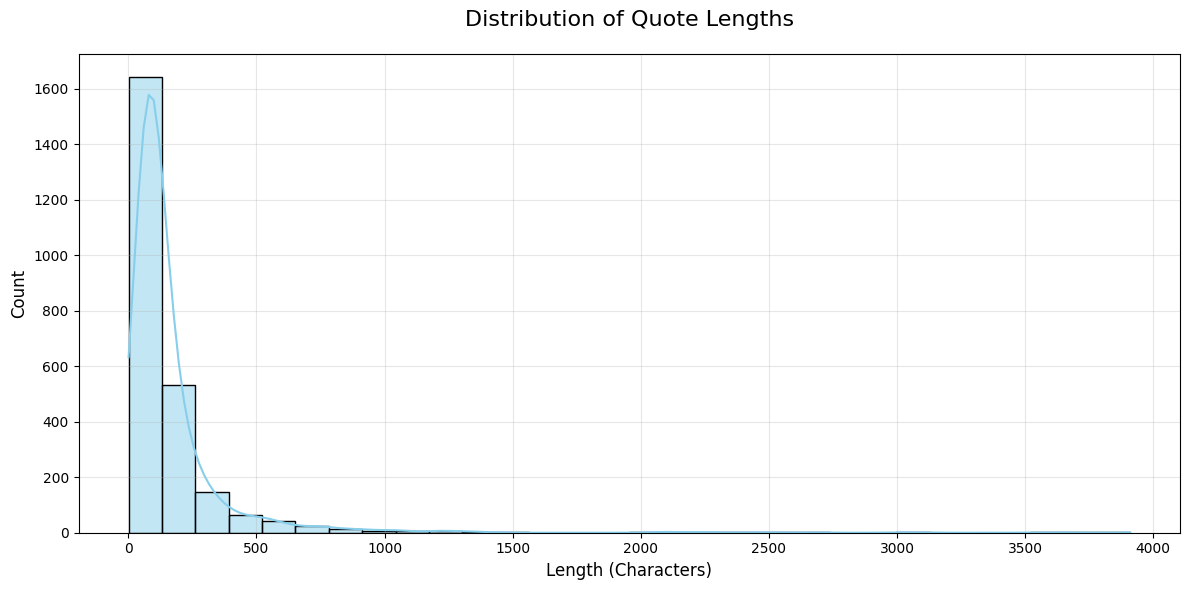

quote length distribution chart saved as quote_length_distribution.png


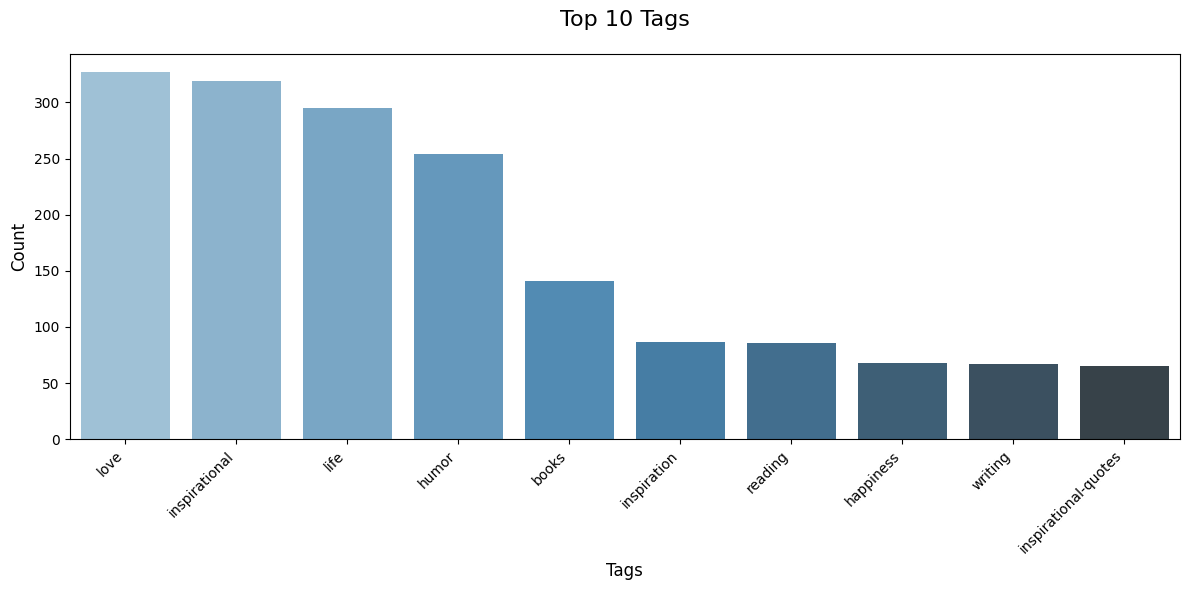

top tags chart saved as top_tags.png


In [31]:
# Cell: Generate Both Improved Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

# Ensure df is available (from previous cells where data was loaded)

# Visualization 1: Quote Length Distribution
df['quote_length'] = df['quote'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(df['quote_length'], bins=30, color='skyblue', kde=True)
plt.title('Distribution of Quote Lengths', fontsize=16, pad=20)
plt.xlabel('Length (Characters)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('quote_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("quote length distribution chart saved as quote_length_distribution.png")

# Visualization 2: Top 10 Tags
all_tags = []
for tags in df['tags']:
    all_tags.extend(tags)
top_tags = pd.Series(Counter(all_tags)).sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_tags.index, y=top_tags.values, palette='Blues_d')
plt.title('Top 10 Tags', fontsize=16, pad=20)
plt.xlabel('Tags', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('top_tags.png', dpi=300, bbox_inches='tight')
plt.show()
print("top tags chart saved as top_tags.png")